In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binom
import seaborn as sns
import numpy as np
# import itertools
#import matplotlib.ticker as ticker
#from matplotlib.ticker import NullFormatter
#from bokeh.plotting import show
#from bokeh.layouts import gridplot
#from sklearn import metrics
#from sklearn.metrics import classification_report, confusion_matrix, jaccard_score, f1_score, log_loss, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
#from matplotlib.pyplot import matshow
#%matplotlib inline

# Selection, transformation, pre-processing and visualization of data loaded from CSV file

## Let's get to know the data set we are working with

In [2]:
# Load the data and get a sample of it
df = pd.read_csv("loans.csv")
df.sample(10)

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
235,273,273,PAIDOFF,1000,30,9/14/2016,10/13/2016,35,High School or Below,male
276,323,323,COLLECTION,800,15,9/10/2016,9/24/2016,32,college,male
16,18,18,PAIDOFF,1000,30,9/10/2016,10/9/2016,32,High School or Below,male
70,86,86,PAIDOFF,1000,30,9/11/2016,10/10/2016,24,High School or Below,female
43,52,52,PAIDOFF,800,15,9/11/2016,9/25/2016,35,Bechalor,female
371,167,167,PAIDOFF,800,30,9/12/2016,10/11/2016,28,college,male
349,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
87,108,108,PAIDOFF,1000,30,9/11/2016,10/10/2016,28,college,male
94,115,115,PAIDOFF,1000,15,9/11/2016,9/25/2016,25,High School or Below,male
332,385,385,COLLECTION,1000,30,9/11/2016,11/9/2016,26,High School or Below,male


In [3]:
# Let's check the summary statistics for numeric features
df.describe()

,Unnamed: 0.1,Unnamed: 0,Principal,terms,age
count,400.000000,400.000000,400.00000,400.000000,400.000000
mean,199.500000,199.500000,939.75000,22.550000,31.060000
std,115.614301,115.614301,120.33761,8.100094,6.033441
min,0.000000,0.000000,300.00000,7.000000,18.000000
25%,99.750000,99.750000,800.00000,15.000000,27.000000
50%,199.500000,199.500000,1000.00000,30.000000,30.000000
75%,299.250000,299.250000,1000.00000,30.000000,35.000000
max,399.000000,399.000000,1000.00000,30.000000,51.000000


In [4]:
# Let's check the skewness and spread of the variables
df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'loan_status', 'effective_date', 'due_date', 'education', 'Gender'], axis=1).agg([np.median, np.var, np.std])

,Principal,terms,age
median,1000.000000,30.000000,30.000000
var,14481.140351,65.611529,36.402406
std,120.337610,8.100094,6.033441


In [5]:
# Let's check the summary statistics for categorical features
df.describe(include=['O'])

,loan_status,effective_date,due_date,education,Gender
count,400,400,400,400,400
unique,2,7,24,4,2
top,PAIDOFF,9/11/2016,10/10/2016,High School or Below,male
freq,300,190,98,172,337


In [6]:
# Let's look for non-existing values!
df.isnull().sum()

Unnamed: 0.1      0
Unnamed: 0        0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [7]:
# Check data types and some more info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    400 non-null    int64 
 1   Unnamed: 0      400 non-null    int64 
 2   loan_status     400 non-null    object
 3   Principal       400 non-null    int64 
 4   terms           400 non-null    int64 
 5   effective_date  400 non-null    object
 6   due_date        400 non-null    object
 7   age             400 non-null    int64 
 8   education       400 non-null    object
 9   Gender          400 non-null    object
dtypes: int64(5), object(5)
memory usage: 31.4+ KB


***It has been found that some of the features are not relevant or they are not in the correct data type***

In [8]:
# Eliminate the unnecessary features
df = df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [9]:
# Convert the data type from object to datetime
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   loan_status     400 non-null    object        
 1   Principal       400 non-null    int64         
 2   terms           400 non-null    int64         
 3   effective_date  400 non-null    datetime64[ns]
 4   due_date        400 non-null    datetime64[ns]
 5   age             400 non-null    int64         
 6   education       400 non-null    object        
 7   Gender          400 non-null    object        
dtypes: datetime64[ns](2), int64(3), object(3)
memory usage: 25.1+ KB


In [10]:
df.nunique()

loan_status        2
Principal          6
terms              3
effective_date     7
due_date          24
age               32
education          4
Gender             2
dtype: int64

## Let's analyze and visualize the different features depending on whether or not customers repay the loan on time

***This is what we know from a first analysis:*** \
***We know that there more man then women.*** \
***We know from the summary statistics that the minimum principal amount was $300 and the maximum was $1000, and looking at the unique values we know that only 6 different principal amounts were requested.*** \
***We know that the minimum age registered was 19 years old and the maximum age was 51 years old, and looking at the unique values we know that 32 different ages were registered.***

***Let's go a little deeper with this knowledge.***

***Of the 400 people, we can see that 300 paid the loans on time and the remaining 100 went into collection by missing the deadline, the classes are unbalanced.***

In [11]:
df['loan_status'].value_counts()

PAIDOFF       300
COLLECTION    100
Name: loan_status, dtype: int64

***Of the 400 people, we can see that 337 (84.25%) are male and 63 (15.75%) are female.***

In [47]:
df['Gender'].value_counts()

0    337
1     63
Name: Gender, dtype: int64

In [13]:
df['Gender'].value_counts(normalize=True) * 100

male      84.25
female    15.75
Name: Gender, dtype: float64

***Of these 63 women, 84.13% paid on time and the other 15.87% did not pay on time. Of the 337 men, 73.29% paid on time and 26.71% did not pay on time.***

In [49]:
groupby_gender = df.groupby(['Gender'])['loan_status'].value_counts(normalize=True) * 100
groupby_gender.unstack(level=-1)

loan_status,COLLECTION,PAIDOFF
Gender,,
0,26.706231,73.293769
1,15.873016,84.126984


# HERE in work

***What is the probability that the customer is a woman?*** \
***Who is more likely to repay the loan?*** \
***With an average of 57 loans approval a day (400/7)***

In [15]:
# estimative of collections by sex
num_days = 7
num_clients_per_day = 57

# probability of being a women
num_F = np.mean(binom.rvs(num_clients_per_day, 0.1575, size=num_days))
p_F = binom.pmf(num_F, num_clients_per_day, 0.1575)

# probability of entering in collection if it was a female
num_FC = np.mean(binom.rvs(num_clients_per_day, 0.1587, size=num_days))
p_FC = binom.pmf(num_FC, num_clients_per_day, 0.1575)

# probability of entering in collection if it was a male
num_MC = np.mean(binom.rvs(num_clients_per_day, 0.2671, size=num_days))
p_MC = binom.pmf(num_MC, num_clients_per_day, 0.8425)

"Probability of being female: " + str(p_F) + " \n", "Probability of being female and entering collection: " + str(p_FC) + " \n", "Probability of being male and entering collection: " + str(p_MC)

('Probability of being female: 0.0 \n',
 'Probability of being female and entering collection: 0.1287965826243939 \n',
 'Probability of being male and entering collection: 3.25760071641537e-22')

# UP HERE in work

***In this bar chart we can visually confirm that it is more usual for the loan to be in the name of a man, and there is a tendency for people to choose/need higher principal values than lower ones.***

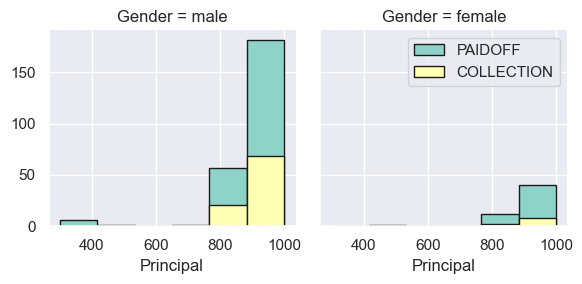

In [16]:
# Plot the bar chart to visualize principal values by gender
sns.set(style='darkgrid')

bins = np.linspace(df.Principal.min(), df.Principal.max(), 7)

g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

# HERE translate from here
In this bar chart we can visually confirm that it is more usual for the loan to be in the name of a man, and there is a tendency for people to choose/need higher principal values than lower ones.

***Olhemos então para a quantidade de pessoas que consoante o sexo e a idade que pagam ou não pagam os empréstimos e quais as idades em que mais se verifica que há mais pedidos***

*Podemos observar que há mais pessoas a pedir emprestimos a partir dos 25 anos, podemos associar ao facto de ser quando maior parte das pessoas começa a ter a sua independência e os seus planos de vida a concretizarem-se mas não há qualquer tipo de correlação que comprove esse facto*

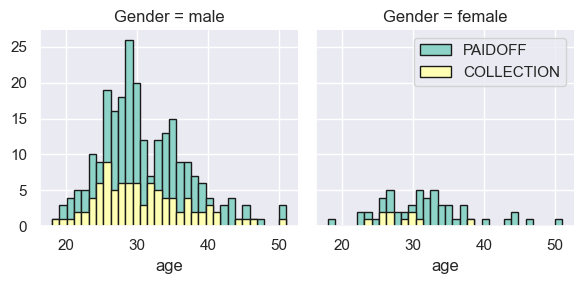

In [17]:
# Plot the bar chart to visualize loan status trow ages split by gender
bins=np.linspace(df.age.min(), df.age.max(), 33)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

***Olhemos então para a quantidade de pessoas que consoante o nível de escolaridade e a idade, se pagam ou não pagam os emprestimos e quais as idades em que mais se verifica que há mais pedidos***

In [44]:
group_by_edu = df.groupby('loan_status')['education'].value_counts(normalize=True) * 100
group_by_edu.unstack(level=-1)

education,Bechalor,High School or Below,Master or Above,college
loan_status,,,,
COLLECTION,11.000000,49.0,1.0,39.000000
PAIDOFF,13.666667,41.0,1.0,44.333333


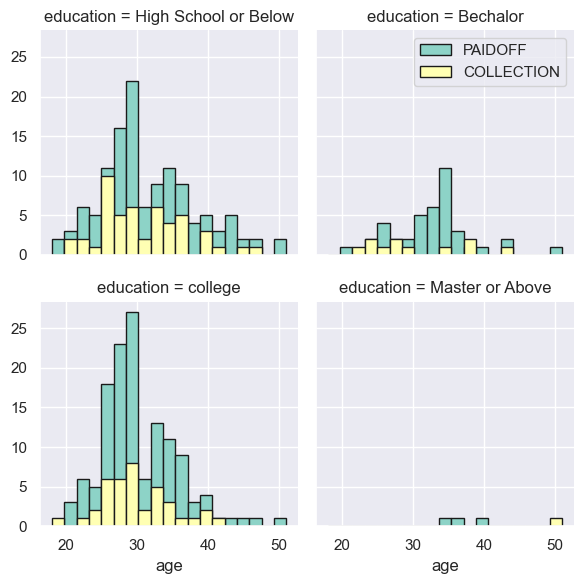

In [19]:
bins=np.linspace(df.age.min(), df.age.max(), 20)
g = sns.FacetGrid(df, col="education", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[1].legend()
plt.show()

*A olho nu vemos algumas diferenças mas não podemos confiar na visão em coisas tão semelhantes, podemos mais a frente avaliar a situação de forma numérica e verificar se vale a pena normalizar esses dados para tirar conclusões mais precisas*

***Olhemos então para a quantidade de pessoas que consoante o empréstimo que fazem e o prazo dos mesmo, se pagam ou não pagam os empréstimos e quais os prazos e valores de empréstimo em que se verifica que há mais pessoas a pagar ou a entrar em coleta***

In [20]:
df[["loan_status", "Principal"]].groupby(['loan_status'], as_index=False).mean()

,loan_status,Principal
0,COLLECTION,954.0
1,PAIDOFF,935.0


In [21]:
df[["terms", "Principal"]].groupby(['terms'], as_index=False).mean()

,terms,Principal
0,7,750.000000
1,15,893.452381
2,30,994.339623


In [22]:
df[["loan_status", "terms"]].groupby(['loan_status'], as_index=False).mean()

,loan_status,terms
0,COLLECTION,23.850000
1,PAIDOFF,22.116667


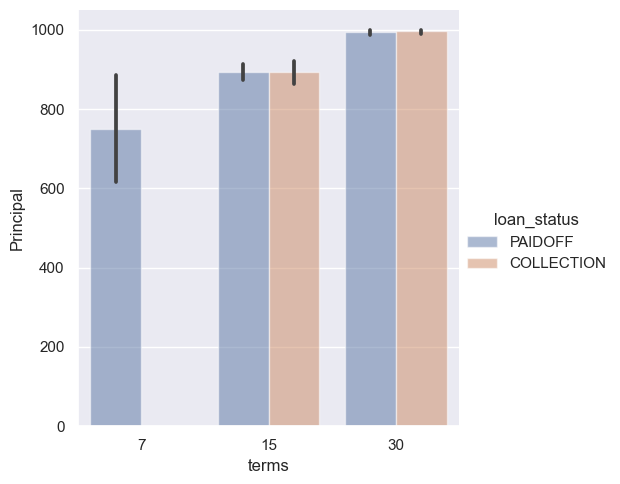

In [23]:
sns.catplot(data=df, x="terms", y="Principal", hue="loan_status", kind="bar", alpha=.5, height=5)
sns.set(style='darkgrid')

Através deste gráfico e outras observações, já conseguimos arranjar uma correlação mais concisa, conseguimos observar que as pessoas que costumam pedir emprestimos com prazos mais curtos costumam pagar mais atempadamente

***Olhemos então para a quantidade de pessoas que consoante o dia da semana em que fazem o pedido e a idade, se pagam ou não pagam os empréstimos e quais os dias em que mais se verifica que há mais pedidos***

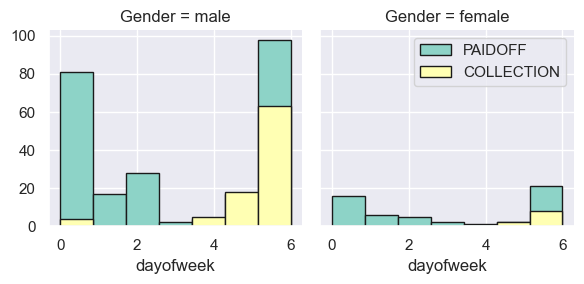

In [24]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins=np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")


g.axes[-1].legend()
plt.show()

In [25]:
df['dayofweek'].value_counts(normalize=True) * 100

6    47.50
0    25.25
5     9.75
2     8.25
1     5.75
4     2.50
3     1.00
Name: dayofweek, dtype: float64

*Através deste gráfico já conseguimos arranjar uma correlação mais concisa, conseguimos observar que as pessoas que costumam pedir emprestimos ao fim de semana costumam atrasar se a pagar*

***Depois da última observação o mais adequado é separar o fim de semana dos dias da semana***

In [26]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.sample(10)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
307,COLLECTION,1000,30,2016-09-11,2016-10-10,32,college,male,6,1
57,PAIDOFF,1000,30,2016-09-11,2016-10-10,43,Bechalor,male,6,1
115,PAIDOFF,800,15,2016-09-11,2016-09-25,32,High School or Below,female,6,1
53,PAIDOFF,1000,30,2016-09-11,2016-10-10,45,college,male,6,1
126,PAIDOFF,800,15,2016-09-12,2016-09-26,35,Bechalor,male,0,0
78,PAIDOFF,1000,30,2016-09-11,2016-10-10,34,college,male,6,1
120,PAIDOFF,800,15,2016-09-11,2016-09-25,35,college,male,6,1
29,PAIDOFF,1000,30,2016-09-11,2016-10-10,37,college,male,6,1
234,PAIDOFF,1000,30,2016-09-14,2016-11-12,28,college,male,2,0
293,COLLECTION,1000,15,2016-09-11,2016-09-25,50,Master or Above,male,6,1


### Conversão de features categóricas para numéricas

***Feature género, podemos então colocá-lo como valor binário***

In [27]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.sample(5)

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
332,COLLECTION,1000,30,2016-09-11,2016-11-09,26,High School or Below,0,6,1
338,COLLECTION,800,15,2016-09-11,2016-09-25,35,High School or Below,0,6,1
24,PAIDOFF,1000,30,2016-09-11,2016-10-10,31,college,0,6,1
23,PAIDOFF,1000,15,2016-09-10,2016-09-24,34,Bechalor,0,5,1
56,PAIDOFF,1000,30,2016-09-11,2016-10-10,37,High School or Below,0,6,1


***Os últimos valores categóricos estão na feature educação, iremos avaliar se são bons dados para tirar conclusões visto que os plots foram inconclusivos***

In [28]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True) * 100

education             loan_status
Bechalor              PAIDOFF        78.846154
                      COLLECTION     21.153846
High School or Below  PAIDOFF        71.511628
                      COLLECTION     28.488372
Master or Above       PAIDOFF        75.000000
                      COLLECTION     25.000000
college               PAIDOFF        77.325581
                      COLLECTION     22.674419
Name: loan_status, dtype: float64

*A entropia em quase todas as categorias é baixa, no entanto nos mestrados ou a cima a entropia é de 1, logo não é boa ideia alimentar esses dados ao modelo de dados temos de a retirar*

## Seleção das Features

***Vamos agora fazer um novo Data Frame com as features definitivas com que queremos alimentar os nossos modelos***

In [29]:
Feature = df[['Principal', 'terms', 'age', 'Gender', 'weekend', 'dayofweek']]
Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis=1)
Feature.head(5)

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,3,0,1,0,0
1,1000,30,33,1,0,3,1,0,0,0
2,1000,15,27,0,0,3,0,0,0,1
3,1000,30,28,1,1,4,0,0,0,1
4,1000,30,29,0,1,4,0,0,0,1


*Usamos um método de algoritmo "dummie" do pandas para fazer a normalização dos dados na feature educação e retiramos então a categoria mestrados*

C:\Users\util\AppData\Local\Temp\ipykernel_20336\1662391026.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),vmax=1.0,  annot=True, cmap="Greens")


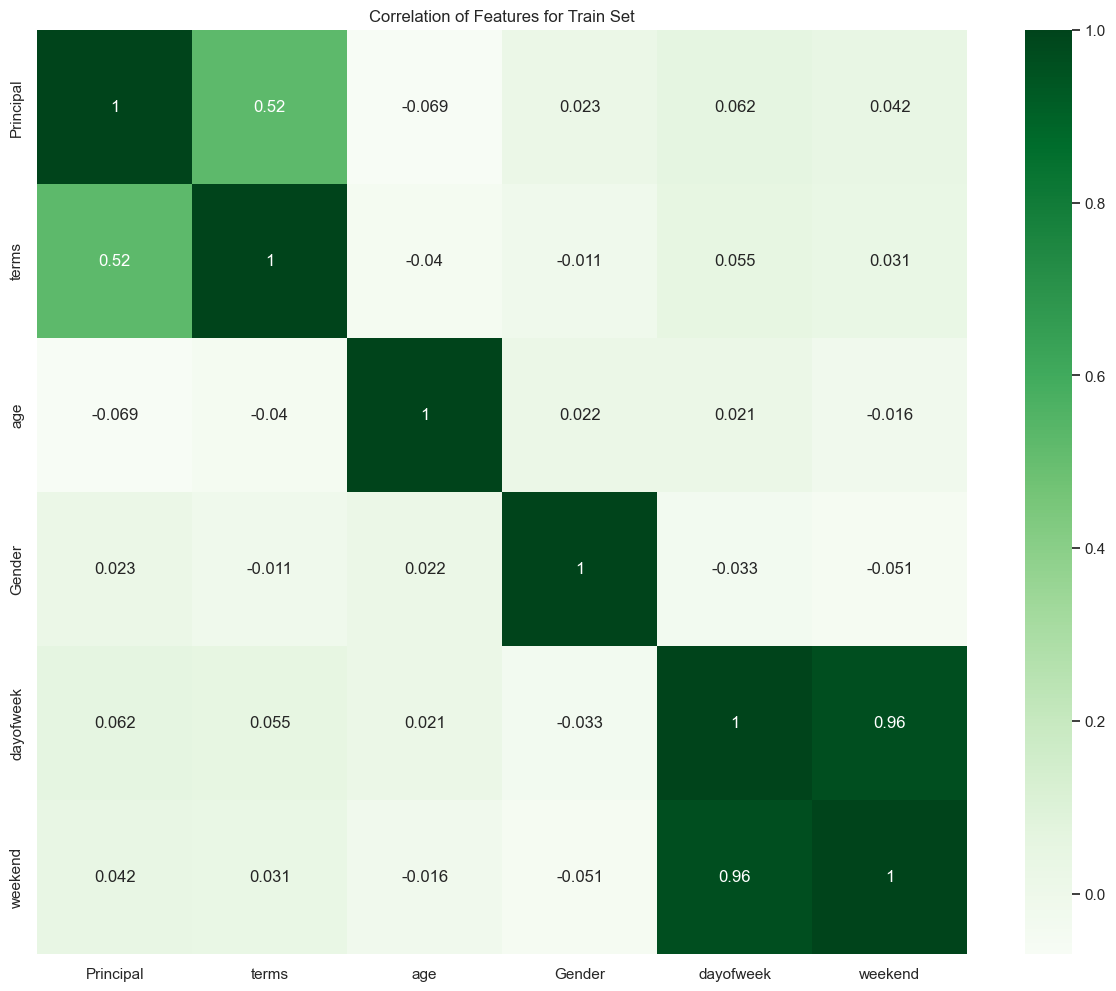

In [30]:
#HeatMap
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set')
sns.heatmap(df.corr(),vmax=1.0,  annot=True, cmap="Greens")
plt.show()

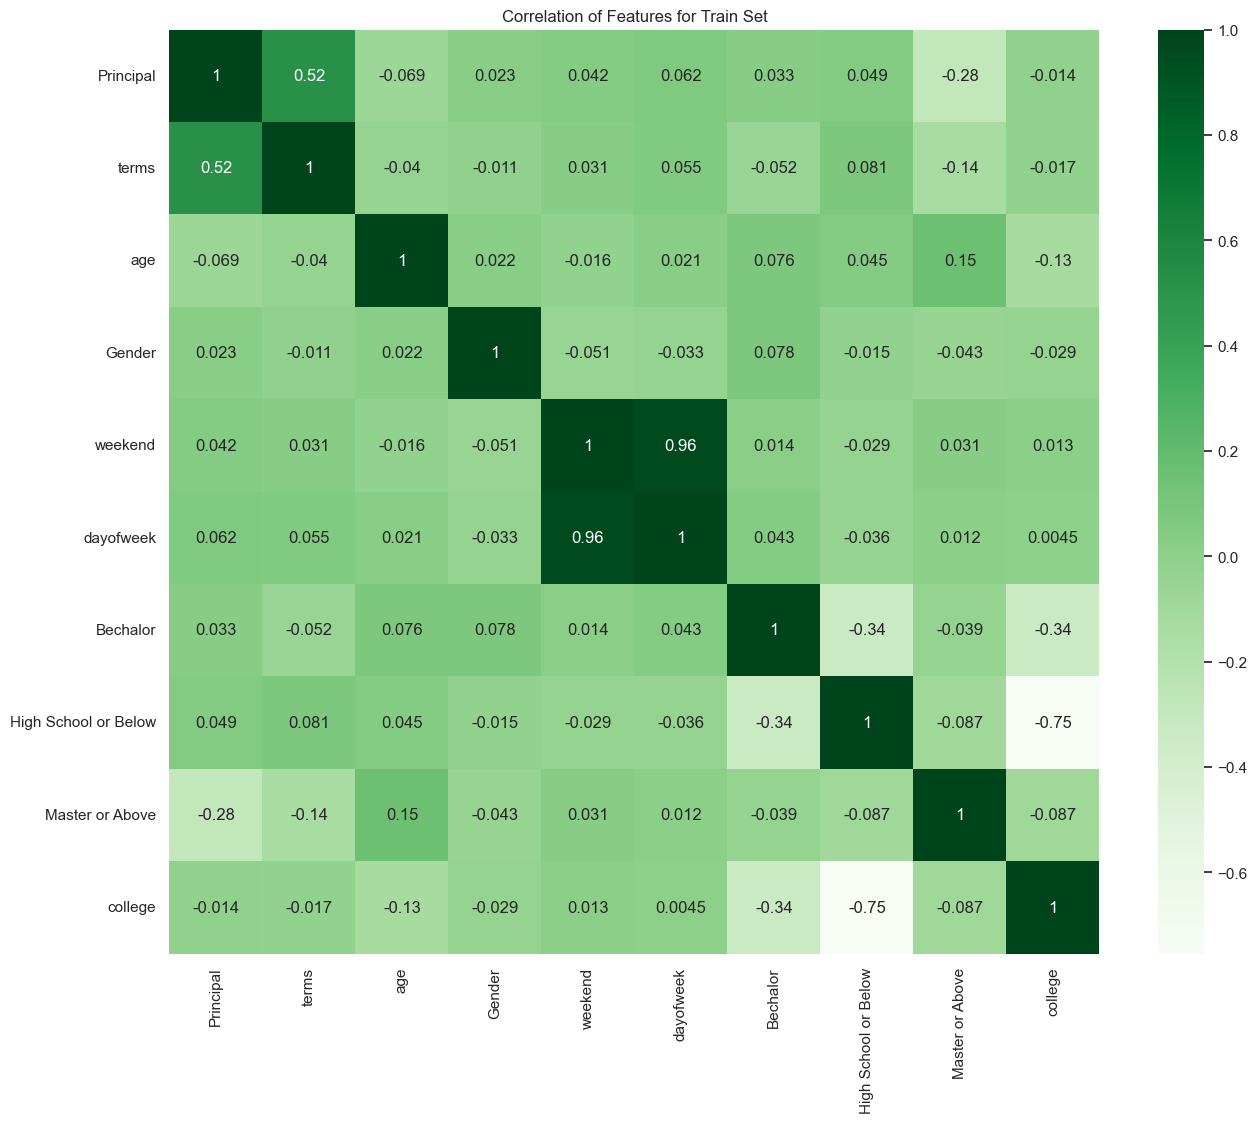

In [31]:
#HeatMap
plt.figure(figsize=(15,12))
plt.title('Correlation of Features for Train Set')
sns.heatmap(Feature.corr(),vmax=1.0,  annot=True, cmap="Greens")
plt.show()

In [32]:
X = Feature
X[0:10]

,Principal,terms,age,Gender,weekend,dayofweek,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,3,0,1,0,0
1,1000,30,33,1,0,3,1,0,0,0
2,1000,15,27,0,0,3,0,0,0,1
3,1000,30,28,1,1,4,0,0,0,1
4,1000,30,29,0,1,4,0,0,0,1
5,1000,30,36,0,1,4,0,0,0,1
6,1000,30,28,0,1,4,0,0,0,1
7,800,15,26,0,1,5,0,0,0,1
8,300,7,29,0,1,5,0,0,0,1
9,1000,15,39,0,1,5,0,1,0,0


In [33]:
y = df['loan_status']
y.shape

(400,)

### Normalização dos dados

In [34]:
from sklearn import preprocessing

X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.50130175,  0.92089421,  2.31334964, -0.43236977, -1.21838912,
        -0.26462433, -0.38655567,  1.15133896, -0.10050378, -0.86855395],
       [ 0.50130175,  0.92089421,  0.32194392,  2.31283513, -1.21838912,
        -0.26462433,  2.5869495 , -0.86855395, -0.10050378, -0.86855395],
       [ 0.50130175, -0.9332552 , -0.67375893, -0.43236977, -1.21838912,
        -0.26462433, -0.38655567, -0.86855395, -0.10050378,  1.15133896],
       [ 0.50130175,  0.92089421, -0.50780846,  2.31283513,  0.82075585,
         0.11888919, -0.38655567, -0.86855395, -0.10050378,  1.15133896],
       [ 0.50130175,  0.92089421, -0.34185798, -0.43236977,  0.82075585,
         0.11888919, -0.38655567, -0.86855395, -0.10050378,  1.15133896]])

# Classificação, qual o método que se adequa mais e obtém mais *accuracy*

## Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (340, 10) (340,)
Test set: (60, 10) (60,)


## K-Nearest Neighbors

### Training (Para encontrar o melhor k)

In [36]:
from sklearn.neighbors import KNeighborsClassifier

k = 3
eKNN = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
eKNN

KNeighborsClassifier(n_neighbors=3)

### Prediction (Para encontrar o melhor k)

In [37]:
yhat_knn = eKNN.predict(X_test)
yhat_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Visualization

In [38]:
Ks=10
mean_acc=np.zeros((Ks-1))
std_acc=np.zeros((Ks-1))
ConfusionMx = [];

for k in range(1,Ks):
    
    
    kNN_type = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat_knn = kNN_type.predict(X_test)
    
    
    mean_acc[k-1]=np.mean(yhat_knn==y_test);
    
    std_acc[k-1]=np.std(yhat_knn==y_test)/np.sqrt(yhat_knn.shape[0])
mean_acc * 100

array([66.66666667, 63.33333333, 65.        , 65.        , 70.        ,
       66.66666667, 66.66666667, 66.66666667, 68.33333333])

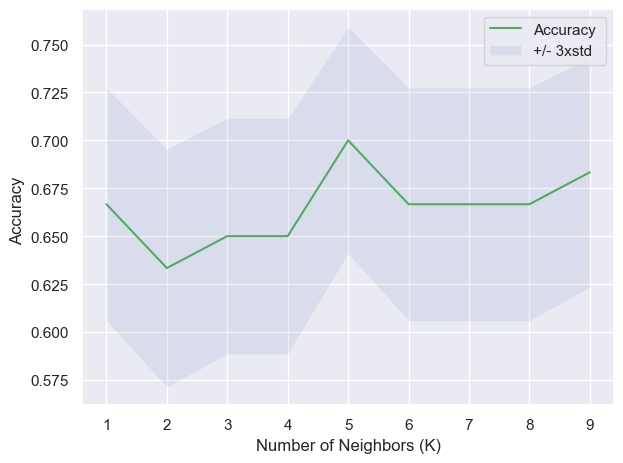

The best accuracy was 70 % with k= 5


In [39]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/­ 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()
print( "The best accuracy was", int(mean_acc.max() * 100), "% with k=", mean_acc.argmax()+1) 

### Modeling

In [40]:
k = 1
eKNN = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
eKNN

KNeighborsClassifier(n_neighbors=1)

### Evaluate KNN Predict

In [41]:
yhat_knn_pred = eKNN.predict(X_test)
yhat_prob_knn = eKNN.predict_proba(X_test)

### KNN Model Accuracy

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [43]:
cmKNN = confusion_matrix(y_test, yhat_knn_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmKNN, classes=['PAIDOFF', 'COLLECTION'], normalize= False, title='Confusion matrix')

NameError: name 'confusion_matrix' is not defined

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


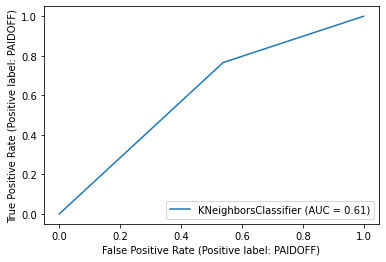

In [ ]:
metrics.plot_roc_curve(eKNN, X_test, y_test)
plt.show()

In [ ]:
print ("KNN - Logloss é: %.2f" % log_loss(y_test, yhat_prob_knn))
print ("KNN - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_knn_pred, pos_label='PAIDOFF'))
print ("KNN - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_knn_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_knn_pred))

KNN - Logloss é: 10.36
KNN - Jaccard para PAIDOFF é: 0.67
KNN - Jaccard para COLLECTION é: 0.25
              precision    recall  f1-score   support

  COLLECTION       0.35      0.46      0.40        13
     PAIDOFF       0.84      0.77      0.80        47

    accuracy                           0.70        60
   macro avg       0.60      0.61      0.60        60
weighted avg       0.73      0.70      0.71        60



## Árvore de Decisão

### Modeling

In [ ]:
from sklearn.tree import DecisionTreeClassifier

eTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
eTree

DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [ ]:
eTree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Visualization

In [ ]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

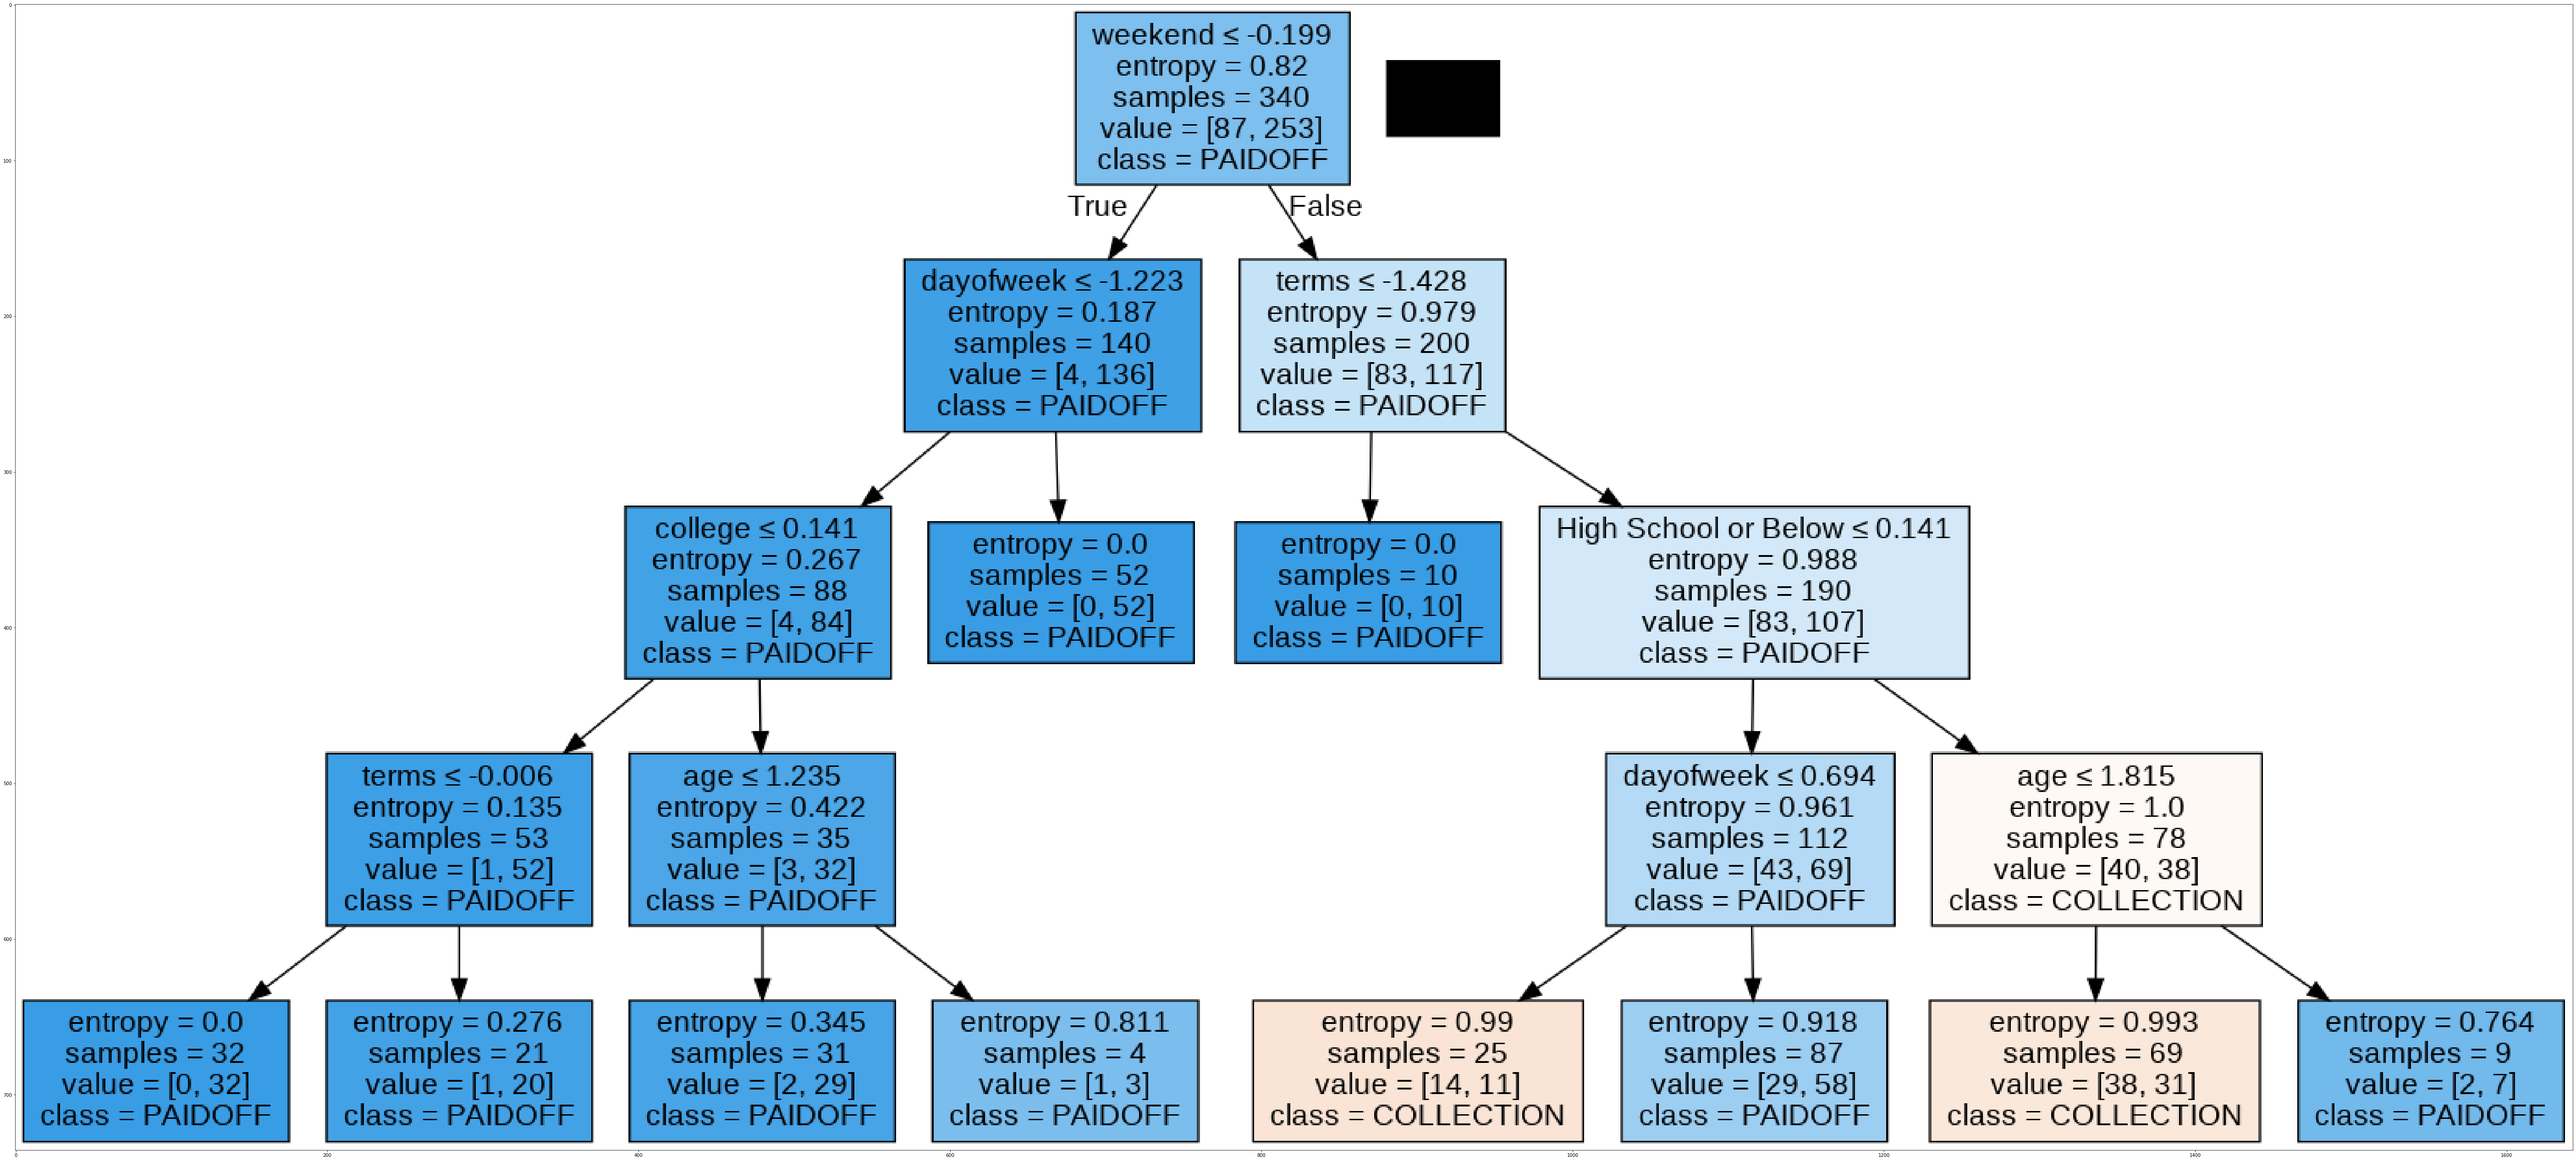

In [ ]:
dot_data = StringIO()
filename = "eTree.png"
featureNames = Feature.columns[0:10]
out=tree.export_graphviz(eTree, feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train), filled=True,  special_characters=True, rotate=False)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Evaluate DT Predict

In [ ]:
yhat_dt_pred = eTree.predict(X_test)
yhat_prob_dt = eTree.predict_proba(X_test)

### DT Model Accuracy

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[37 10]
 [ 5  8]]


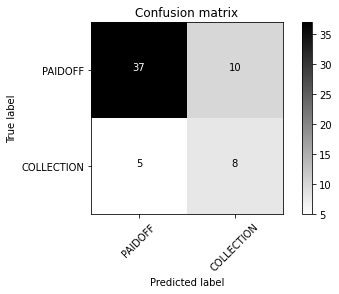

In [ ]:
cmDT = confusion_matrix(y_test, yhat_dt_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmDT, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


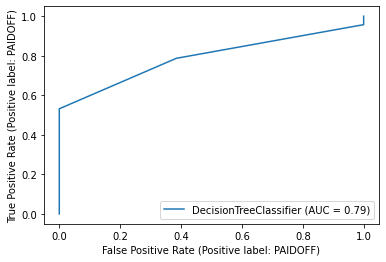

In [ ]:
metrics.plot_roc_curve(eTree, X_test, y_test)
plt.show()

In [ ]:
print ("DT - Logloss é: %.2f" % log_loss(y_test, yhat_prob_dt))
print ("DT - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_dt_pred, pos_label='PAIDOFF'))
print ("DT - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_dt_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_dt_pred))

DT - Logloss é: 0.41
DT - Jaccard para PAIDOFF é: 0.71
DT - Jaccard para COLLECTION é: 0.35
              precision    recall  f1-score   support

  COLLECTION       0.44      0.62      0.52        13
     PAIDOFF       0.88      0.79      0.83        47

    accuracy                           0.75        60
   macro avg       0.66      0.70      0.67        60
weighted avg       0.79      0.75      0.76        60



## SVM

### Modeling

In [ ]:
import scipy.optimize as opt
from sklearn import svm

eSVMrbf = svm.SVC(kernel='rbf')
eSVMrbf.fit(X_train, y_train)

SVC()

In [ ]:
eSVMpoly = svm.SVC(kernel='poly')
eSVMpoly.fit(X_train, y_train)

SVC(kernel='poly')

In [ ]:
eSVMsig = svm.SVC(kernel='sigmoid')
eSVMsig.fit(X_train, y_train)

SVC(kernel='sigmoid')

### Evaluate SVM Predict

In [ ]:
yhat_SVMrbf_pred = eSVMrbf.predict(X_test)
yhat_SVMpoly_pred = eSVMpoly.predict(X_test)
yhat_SVMsig_pred = eSVMsig.predict(X_test)

### SVM Model Accuracy 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[40  7]
 [ 7  6]]
Confusion matrix, without normalization
[[44  3]
 [11  2]]
Confusion matrix, without normalization
[[39  8]
 [ 5  8]]


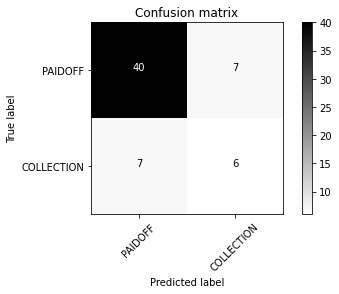

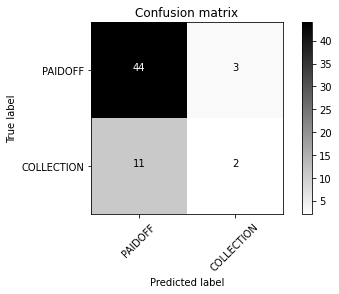

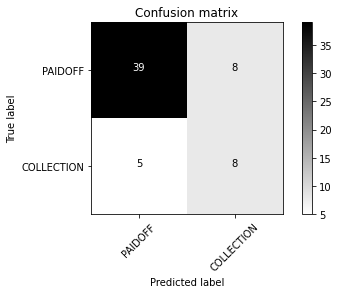

In [ ]:
cmSVMrbf = confusion_matrix(y_test, yhat_SVMrbf_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmSVMrbf, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')

#############################################################################################################

cmSVMrbf = confusion_matrix(y_test, yhat_SVMpoly_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmSVMrbf, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')

#############################################################################################################

cmSVMrbf = confusion_matrix(y_test, yhat_SVMsig_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmSVMrbf, classes=['PAIDOFF','COLLECTION'], normalize= False, title='Confusion matrix')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. U

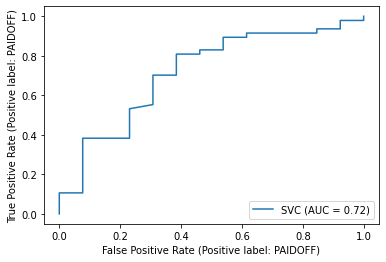

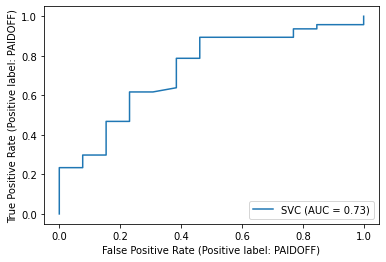

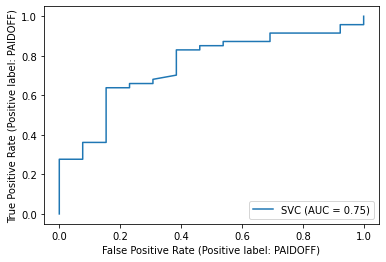

In [ ]:
metrics.plot_roc_curve(eSVMrbf, X_test, y_test)
metrics.plot_roc_curve(eSVMpoly, X_test, y_test)
metrics.plot_roc_curve(eSVMsig, X_test, y_test)
plt.show()

In [ ]:
print('######################################################################')
print ("SVM Radical Basis Function - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_SVMrbf_pred, pos_label='PAIDOFF'))
print ("SVM Radical Basis Function - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_SVMrbf_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_SVMrbf_pred))
print()

print('######################################################################')
print ("SVM Polynomial - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_SVMpoly_pred, pos_label='PAIDOFF'))
print ("SVM Polynomial - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_SVMpoly_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_SVMpoly_pred))
print()

print('######################################################################')
print ("SVM Sigmoid - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_SVMsig_pred, pos_label='PAIDOFF'))
print ("SVM Sigmoid - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_SVMsig_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_SVMsig_pred))

######################################################################
SVM Radical Basis Function - Jaccard para PAIDOFF é: 0.74
SVM Radical Basis Function - Jaccard para COLLECTION é: 0.30
              precision    recall  f1-score   support

  COLLECTION       0.46      0.46      0.46        13
     PAIDOFF       0.85      0.85      0.85        47

    accuracy                           0.77        60
   macro avg       0.66      0.66      0.66        60
weighted avg       0.77      0.77      0.77        60


######################################################################
SVM Polynomial - Jaccard para PAIDOFF é: 0.76
SVM Polynomial - Jaccard para COLLECTION é: 0.12
              precision    recall  f1-score   support

  COLLECTION       0.40      0.15      0.22        13
     PAIDOFF       0.80      0.94      0.86        47

    accuracy                           0.77        60
   macro avg       0.60      0.55      0.54        60
weighted avg       0.71      0.77      0.72 

## Regressão Logistica

### Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression
eLr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)
eLr

LogisticRegression(C=0.01, solver='liblinear')

### Evaluate LR 

In [ ]:
yhat_lr_pred = eLr.predict(X_test)
yhat_prob_lr = eLr.predict_proba(X_test)


### LR Model Accuracy

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.gist_yarg):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat_lr_pred , labels=['PAIDOFF','COLLECTION']))

[[35 12]
 [ 6  7]]


Confusion matrix, without normalization
[[35 12]
 [ 6  7]]


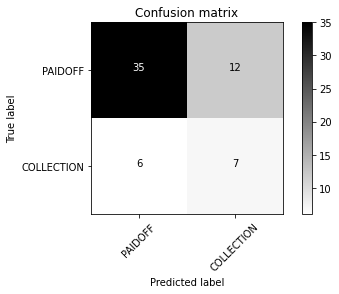

In [ ]:
cmLR = confusion_matrix(y_test, yhat_lr_pred, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cmLR, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


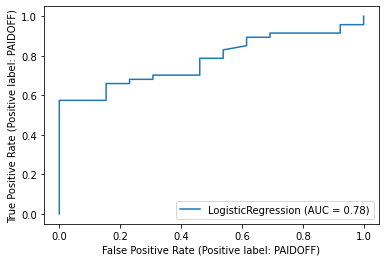

In [ ]:
metrics.plot_roc_curve(eLr, X_test, y_test)
plt.show()

In [ ]:
print ("LR - Logloss é: %.2f" % log_loss(y_test, yhat_prob_lr))
print ("LR - Jaccard para PAIDOFF é: %.2f" % jaccard_score(y_test, yhat_lr_pred, pos_label='PAIDOFF'))
print ("LR - Jaccard para COLLECTION é: %.2f" % jaccard_score(y_test, yhat_lr_pred, pos_label='COLLECTION'))
print (classification_report(y_test, yhat_lr_pred))

LR - Logloss é: 0.55
LR - Jaccard para PAIDOFF é: 0.66
LR - Jaccard para COLLECTION é: 0.28
              precision    recall  f1-score   support

  COLLECTION       0.37      0.54      0.44        13
     PAIDOFF       0.85      0.74      0.80        47

    accuracy                           0.70        60
   macro avg       0.61      0.64      0.62        60
weighted avg       0.75      0.70      0.72        60

